<font color="#CA3532"><h1 align="left">**Práctica 2 de Aprendizaje por Refuerzo**</h1></font>
<font color="#6E6E6E"><h2 align="left">**Multiarmed Bandits**</h2></font>

# **Multiarmed bandits para Credit Scoring**

El objetivo es construir un sistema automático de aprendizaje por refuerzo para gestionar un sistema de concesión de créditos.
La idea es que cuando un cliente contacte con el banco para solicitar un crédito, el sistema se lo conceda (acción 1) o no (acción 0).
Por tanto el sistema de aprendizaje por refuerzo tiene **dos posibles acciones**.

Por otra parte, el reward obtenido es:

- 0 si el sistema decide no ofrecerle el crédito al cliente
- 1 si se le ofrece el crédito y **lo paga**
- -10 si se le ofrece crédito y **no lo paga**

Para construir el sistema disponemos del siguiente dataset: https://drive.google.com/file/d/1TdTDAjndt5sn_7HKwc1PifcaQTRNHzkR/view?usp=sharing


A continuación se descarga y muestra:

In [2]:
COLAB = True

In [3]:
import pandas as pd
pd.options.display.max_colwidth = 200

# Descargamos dataset:
aux = "'https://docs.google.com/uc?export=download&id=1twvCaa27x8aOcwkaMyCu-RxgTe3ivVxR&confirm=t'"
!wget -q $aux -O ./cs.csv
aux = "'https://docs.google.com/uc?export=download&id=1yZNmK6yWl3IzvDGxNZRlyZVbh3oxpO_b&confirm=t'"
!wget -q $aux -O ./DataDictionary.csv

**Información sobre cada variable:**

In [4]:
info_variables = pd.read_csv("DataDictionary.csv", sep=";").set_index("Variable Name")
info_variables

,Unnamed: 0,Description,Type
Variable Name,,,
SeriousDlqin2yrs,0,Person experienced 90 days past due delinquency or worse,Y/N
RevolvingUtilizationOfUnsecuredLines,1,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
age,2,Age of borrower in years,integer
NumberOfTime30-59DaysPastDueNotWorse,3,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
DebtRatio,4,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
MonthlyIncome,5,Monthly income,real
NumberOfOpenCreditLinesAndLoans,6,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
NumberOfTimes90DaysLate,7,Number of times borrower has been 90 days or more past due.,integer
NumberRealEstateLoansOrLines,8,Number of mortgage and real estate loans including home equity lines of credit,integer


**Base de datos:**

In [5]:
df = pd.read_csv("./cs.csv")
df.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [6]:
df.describe().T[["count", "min", "max", "mean", "std"]]

,count,min,max,mean,std
SeriousDlqin2yrs,150000.0,0.0,1.0,0.066840,0.249746
RevolvingUtilizationOfUnsecuredLines,150000.0,0.0,50708.0,6.048438,249.755371
age,150000.0,0.0,109.0,52.295207,14.771866
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.0,98.0,0.421033,4.192781
DebtRatio,150000.0,0.0,329664.0,353.005076,2037.818523
MonthlyIncome,120269.0,0.0,3008750.0,6670.221237,14384.674215
NumberOfOpenCreditLinesAndLoans,150000.0,0.0,58.0,8.452760,5.145951
NumberOfTimes90DaysLate,150000.0,0.0,98.0,0.265973,4.169304
NumberRealEstateLoansOrLines,150000.0,0.0,54.0,1.018240,1.129771
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.0,98.0,0.240387,4.155179


In [7]:
df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [8]:
(df["MonthlyIncome"].isna() & df["NumberOfDependents"].isna()).sum()

np.int64(3924)

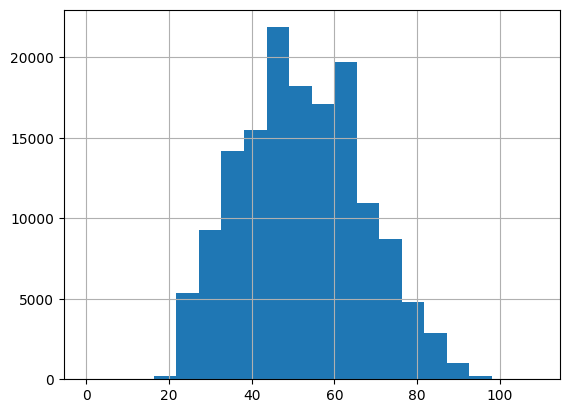

In [9]:
df["age"].hist(bins=20);

In [10]:
df["NumberOfTime30-59DaysPastDueNotWorse"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse
0     126018
1      16033
2       4598
3       1754
4        747
5        342
98       264
6        140
7         54
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: count, dtype: int64

In [11]:
# limpieza básica:
#
# 1- Eliminamos filas con missing values (MonthlyIncome y NumberOfDependents)
# 2- Nos quedamos solo con personas de 18 a 70 años (incluidos)
# 3- Eliminamos filas que tengan 96 o 98 en columnas de retraso
#    (NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse,
#     NumberOfTimes90DaysLate)

df.dropna(inplace=True)
df = df[ (df["age"]>=18) & (df["age"]<=70) ]

df = df[ ~df["NumberOfTime30-59DaysPastDueNotWorse"].isin([96, 98]) ]
df = df[ ~df["NumberOfTime60-89DaysPastDueNotWorse"].isin([96, 98]) ]
df = df[ ~df["NumberOfTimes90DaysLate"].isin([96, 98]) ]

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,107883.0,0.073728,0.261329,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,107883.0,6.262285,268.425237,0.0,0.042982,0.206481,0.617870,50708.0
age,107883.0,48.343835,11.909195,21.0,39.000000,49.000000,58.000000,70.0
NumberOfTime30-59DaysPastDueNotWorse,107883.0,0.276781,0.739606,0.0,0.000000,0.000000,0.000000,13.0
DebtRatio,107883.0,27.426863,395.986811,0.0,0.162018,0.308917,0.493251,60212.0
MonthlyIncome,107883.0,6800.816625,14941.921271,0.0,3500.000000,5500.000000,8344.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,107883.0,8.774265,5.155074,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,107883.0,0.098588,0.509666,0.0,0.000000,0.000000,0.000000,17.0
NumberRealEstateLoansOrLines,107883.0,1.095233,1.157615,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,107883.0,0.072106,0.348840,0.0,0.000000,0.000000,0.000000,11.0


La columna **SeriousDlqin2yrs** es 0 si el cliente paga el crédito, y 1 si no lo paga.

Ahora dividimos el dataset en training y test:

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=1, test_size=0.3, stratify=df["SeriousDlqin2yrs"])

In [14]:
# frecuencia de impagos en training y test (en tanto por 1):
df_train["SeriousDlqin2yrs"].mean(), df_test["SeriousDlqin2yrs"].mean()

(np.float64(0.07373076617495167), np.float64(0.073721612853391))

In [15]:
# Defino clase clientes:

class clientes:
    def __init__(self, df): # self: parámetros internos
        # mi clase va a tener dos parámetros internos:
        # i, df
        self.i = -1 # i: contador (de clientes); índice al último cliente mostrado
        self.df = df
    def cliente(self): # va a simular que llega un cliente
        self.i = self.i + 1
        if self.i == len(self.df):
            self.i = 0
    def get_context(self): # va a extraer datos de ese cliente
        return self.df.iloc[self.i].drop("SeriousDlqin2yrs")
    def get_reward(self, accion): # reward con ese cliente
        # calculo reward:
        if accion==0: # no se da crédito
            return 0
        # se da crédito:
        if self.df.iloc[self.i]["SeriousDlqin2yrs"] == 1: # no paga
            return -10
        return 1 # paga

In [16]:
# clientes: una clase
# cl_train: una instancia de esa clase
# cl_test: otra instancia de esa clase
#
# podemos ver cl_train como una "caja" donde hemos
# metido el dataset de entrenamiento y va a haber
# métodos que me permiten interaccionar con él
#
# Lo mismo con cl_test, pero para los datos de test

cl_train = clientes(df_train)
cl_test  = clientes(df_test)

In [17]:
cl_train.cliente() # simulo que llega un cliente nuevo

In [18]:
cl_train.get_context()

RevolvingUtilizationOfUnsecuredLines        0.064833
age                                        59.000000
NumberOfTime30-59DaysPastDueNotWorse        0.000000
DebtRatio                                   0.156957
MonthlyIncome                           16666.000000
NumberOfOpenCreditLinesAndLoans             5.000000
NumberOfTimes90DaysLate                     0.000000
NumberRealEstateLoansOrLines                1.000000
NumberOfTime60-89DaysPastDueNotWorse        0.000000
NumberOfDependents                          2.000000
Name: 135262, dtype: float64

In [19]:
cl_train.get_context().values

array([6.48325870e-02, 5.90000000e+01, 0.00000000e+00, 1.56956861e-01,
       1.66660000e+04, 5.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 2.00000000e+00])

In [20]:
cl_train.cliente()
cl_train.get_context()

RevolvingUtilizationOfUnsecuredLines       0.209079
age                                       30.000000
NumberOfTime30-59DaysPastDueNotWorse       0.000000
DebtRatio                                  0.129946
MonthlyIncome                           2400.000000
NumberOfOpenCreditLinesAndLoans            7.000000
NumberOfTimes90DaysLate                    0.000000
NumberRealEstateLoansOrLines               0.000000
NumberOfTime60-89DaysPastDueNotWorse       0.000000
NumberOfDependents                         0.000000
Name: 14308, dtype: float64

In [21]:
cl_train.get_reward(1)

1

# **Tareas a realizar**

1- Calcula la evolución del reward total y regret total en training de:
 a) un algoritmo aleatorio
 b) un algoritmo que siempre da el crédito
 c) un algoritmo que nunca da el crédito

 Calcula en otra gráfica la evolución de su reward promedio y regret promedio. ¿Tienen sentido los resultados?

2- Entrena un multiarmed bandit **no contextual** en training. Calcula las mismas métricas que en el punto 1. ¿Cuál es la estrategia que aprende el modelo?

3- Entrena un multiarmed bandit contextual lineal en training. Calcula las mismas métricas que en los puntos anteriores

4- Calcula, para algunos clientes de training, las Q dadas por el modelo para cada acción. Chequea si obtienes los mismos valores calculándolos tú. Chequea si la acción elegida por el modelo es la de mayor Q.

5- Calcula en test el rendimiento del algoritmo de multiarmed bandit. Compáralo con el grupo de control de test (reserva un 10% de clientes en test como grupo de control).

6- Obtén la interpretabilidad del modelo. ¿En qué variables se está fijando para decidir?

7- Qué ocurre en los puntos anteriores si ahora la penalización cuando el banco da un crédito a un cliente que no paga es -1? ¿Y si se va haciendo aún más pequeña la penalización?

8- Optimiza tu sistema haciendo selección de variables.

9- (Opcional). Investiga otras librerías que permitan implementar multiarmed bandits contextuales no lineales. Toma una de ellas y vuelve a realizar la tarea 3.

### Tarea 1

In [22]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def random_policy(context):
    return np.random.choice([0, 1])

def always_grant_policy(context):
    return 1

def never_grant_policy(context):
    return 0

policies = {
    "Random": random_policy,
    "Always Grant": always_grant_policy,
    "Never Grant": never_grant_policy
}

In [24]:
N = len(df_train) # Number of clients in training set

# Store results for plotting
results = {}

# Simulate each policy
for policy_name, policy_func in policies.items():
    cl_train_sim = clientes(df_train.copy()) # Use a copy to ensure df_train is not modified, and re-initialize for fresh client iteration
    
    current_total_reward = 0
    current_total_regret = 0
    
    history_total_rewards = []
    history_total_regrets = []
    
    for step in tqdm(range(N), desc=f"Simulating {policy_name} policy"):
        cl_train_sim.cliente() # Get next client. self.i is updated.
        context = cl_train_sim.get_context() # Context for the current client
        
        # Determine action based on policy
        action = policy_func(context)
        
        # Get actual reward for the chosen action
        actual_reward = cl_train_sim.get_reward(action)
        
        # Determine optimal reward for this client
        # Reward if action 0 (don't grant) for the current client
        # (Accessing cl_train_sim.df.iloc[cl_train_sim.i] to get current client's true outcome)
        reward_if_action_0 = 0 # As per clientes.get_reward(0)
        
        # Reward if action 1 (grant) for the current client
        if cl_train_sim.df.iloc[cl_train_sim.i]["SeriousDlqin2yrs"] == 1: # Client does not pay
            reward_if_action_1 = -10
        else: # Client pays
            reward_if_action_1 = 1
            
        optimal_reward_for_client = max(reward_if_action_0, reward_if_action_1)
        
        # Calculate regret for this step
        regret = optimal_reward_for_client - actual_reward
        
        # Update totals
        current_total_reward += actual_reward
        current_total_regret += regret
        
        # Store evolution
        history_total_rewards.append(current_total_reward)
        history_total_regrets.append(current_total_regret)
        
    results[policy_name] = {
        "total_rewards": history_total_rewards,
        "total_regrets": history_total_regrets
    }

# For discussion: Calculate P(pays) and P(no_pays) from training data
p_no_pay_train = df_train["SeriousDlqin2yrs"].mean()
p_pay_train = 1 - p_no_pay_train
print(f"P(no_pay) in training: {p_no_pay_train:.4f}")
print(f"P(pay) in training: {p_pay_train:.4f}")

Simulating Never Grant policy: 100%|██████████| 75518/75518 [00:09<00:00, 7689.75it/s]

P(no_pay) in training: 0.0737
P(pay) in training: 0.9263


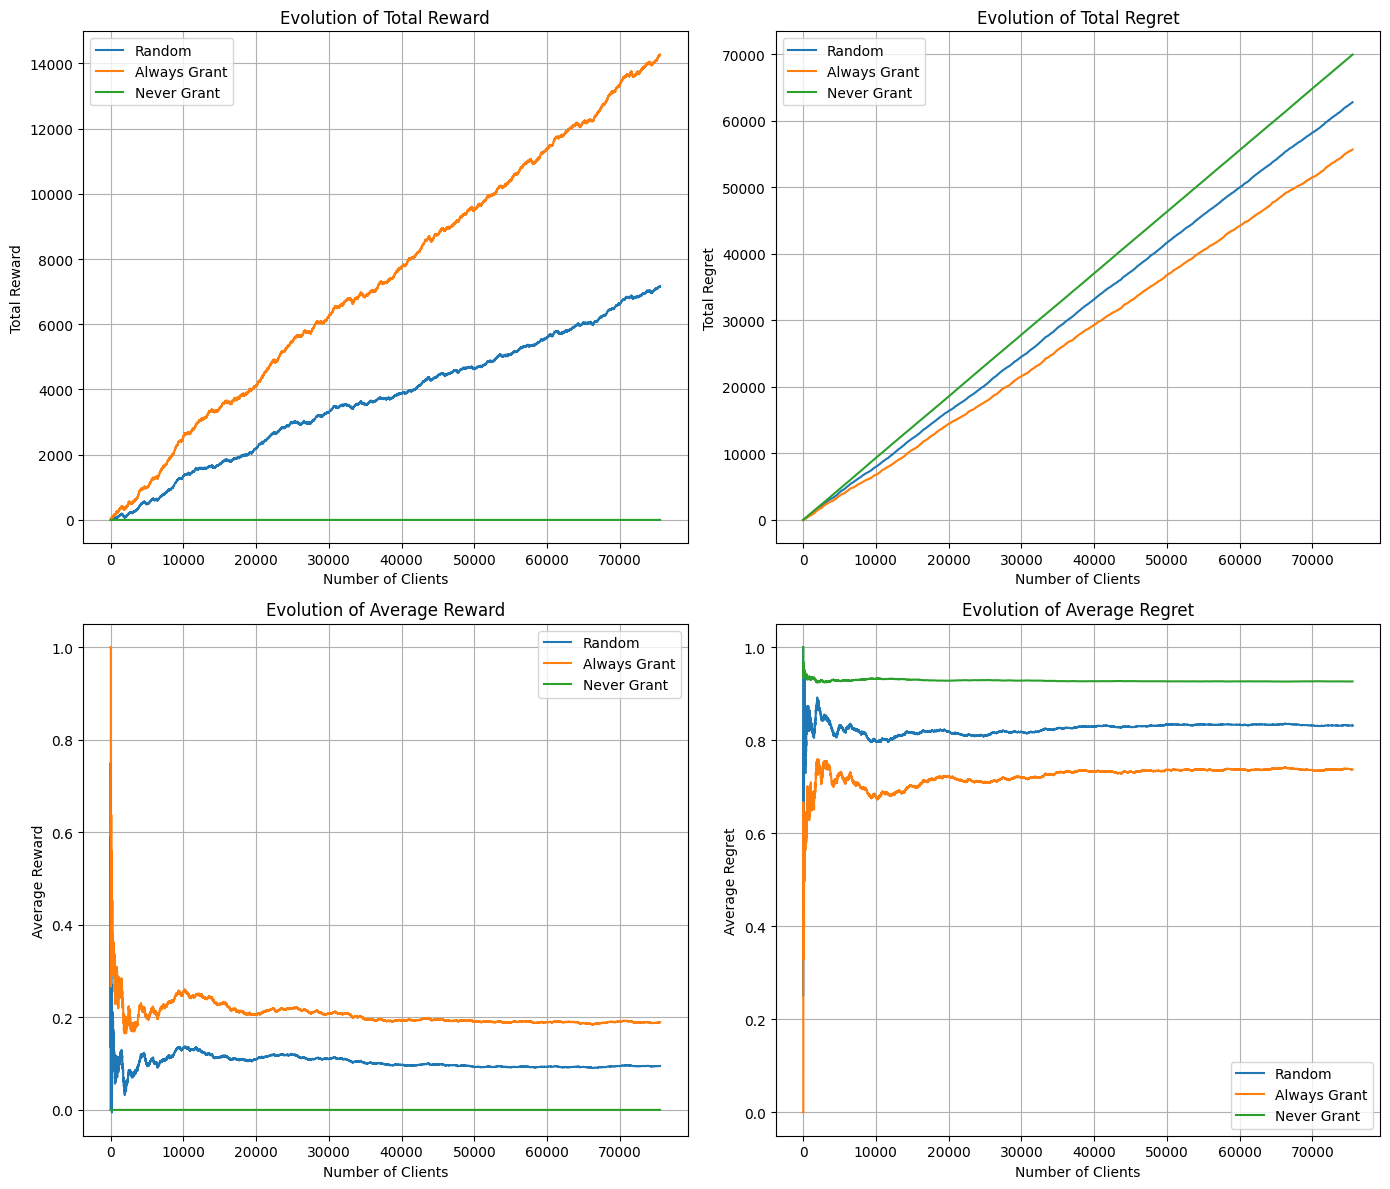

In [25]:
plt.figure(figsize=(14, 12))
iterations = range(1, N + 1)

# Plot 1: Total Reward Evolution
plt.subplot(2, 2, 1)
for policy_name, data in results.items():
    plt.plot(iterations, data["total_rewards"], label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Total Reward")
plt.title("Evolution of Total Reward")
plt.legend()
plt.grid(True)

# Plot 2: Total Regret Evolution
plt.subplot(2, 2, 2)
for policy_name, data in results.items():
    plt.plot(iterations, data["total_regrets"], label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Total Regret")
plt.title("Evolution of Total Regret")
plt.legend()
plt.grid(True)

# Calculate and Plot Average Reward
plt.subplot(2, 2, 3)
for policy_name, data in results.items():
    avg_rewards = [r / i for i, r in zip(iterations, data["total_rewards"])]
    plt.plot(iterations, avg_rewards, label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Average Reward")
plt.title("Evolution of Average Reward")
plt.legend()
plt.grid(True)

# Calculate and Plot Average Regret
plt.subplot(2, 2, 4)
for policy_name, data in results.items():
    avg_regrets = [r / i for i, r in zip(iterations, data["total_regrets"])]
    plt.plot(iterations, avg_regrets, label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Average Regret")
plt.title("Evolution of Average Regret")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Tarea 2

In [26]:
class EpsilonGreedyMAB:
    def __init__(self, num_actions, epsilon=0.1):
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.q_values = np.zeros(num_actions)  # Estimated rewards for each action
        self.action_counts = np.zeros(num_actions) # How many times each action was chosen

    def choose_action(self):
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            return np.random.choice(self.num_actions)
        else:
            # Exploit: choose the action with the highest q_value
            # If multiple actions have the same max q_value, choose one randomly among them
            best_actions = np.where(self.q_values == np.max(self.q_values))[0]
            return np.random.choice(best_actions)

    def update(self, action, reward):
        self.action_counts[action] += 1
        # Incremental average update rule
        self.q_values[action] += (1 / self.action_counts[action]) * (reward - self.q_values[action])

# --- Simulation ---
N_train = len(df_train)
cl_train_sim_mab = clientes(df_train.copy()) # Fresh simulation environment

# Initialize bandit
num_actions = 2 # 0: don't grant, 1: grant
epsilon_mab = EpsilonGreedyMAB(num_actions=num_actions, epsilon=0.1)

# Store results
mab_total_rewards = []
mab_total_regrets = []
current_total_reward_mab = 0
current_total_regret_mab = 0

for step in tqdm(range(N_train), desc="Simulating Epsilon-Greedy MAB"):
    cl_train_sim_mab.cliente() # Get next client
    # Context is not used by this MAB
    
    action = epsilon_mab.choose_action()
    actual_reward = cl_train_sim_mab.get_reward(action)
    epsilon_mab.update(action, actual_reward)
    
    # Optimal reward calculation (same as Tarea 1)
    reward_if_action_0 = 0
    if cl_train_sim_mab.df.iloc[cl_train_sim_mab.i]["SeriousDlqin2yrs"] == 1: # No paga
        reward_if_action_1 = -10
    else: # Paga
        reward_if_action_1 = 1
    optimal_reward_for_client = max(reward_if_action_0, reward_if_action_1)
    
    regret = optimal_reward_for_client - actual_reward
    
    current_total_reward_mab += actual_reward
    current_total_regret_mab += regret
    
    mab_total_rewards.append(current_total_reward_mab)
    mab_total_regrets.append(current_total_regret_mab)

results["EpsilonGreedy_MAB"] = {
    "total_rewards": mab_total_rewards,
    "total_regrets": mab_total_regrets
}

print(f"\nEpsilon-Greedy MAB final Q-values: {epsilon_mab.q_values}")
print(f"Epsilon-Greedy MAB action counts: {epsilon_mab.action_counts}")

Simulating Epsilon-Greedy MAB: 100%|██████████| 75518/75518 [00:04<00:00, 16263.24it/s]


Epsilon-Greedy MAB final Q-values: [0.         0.18611069]
Epsilon-Greedy MAB action counts: [ 3765. 71753.]


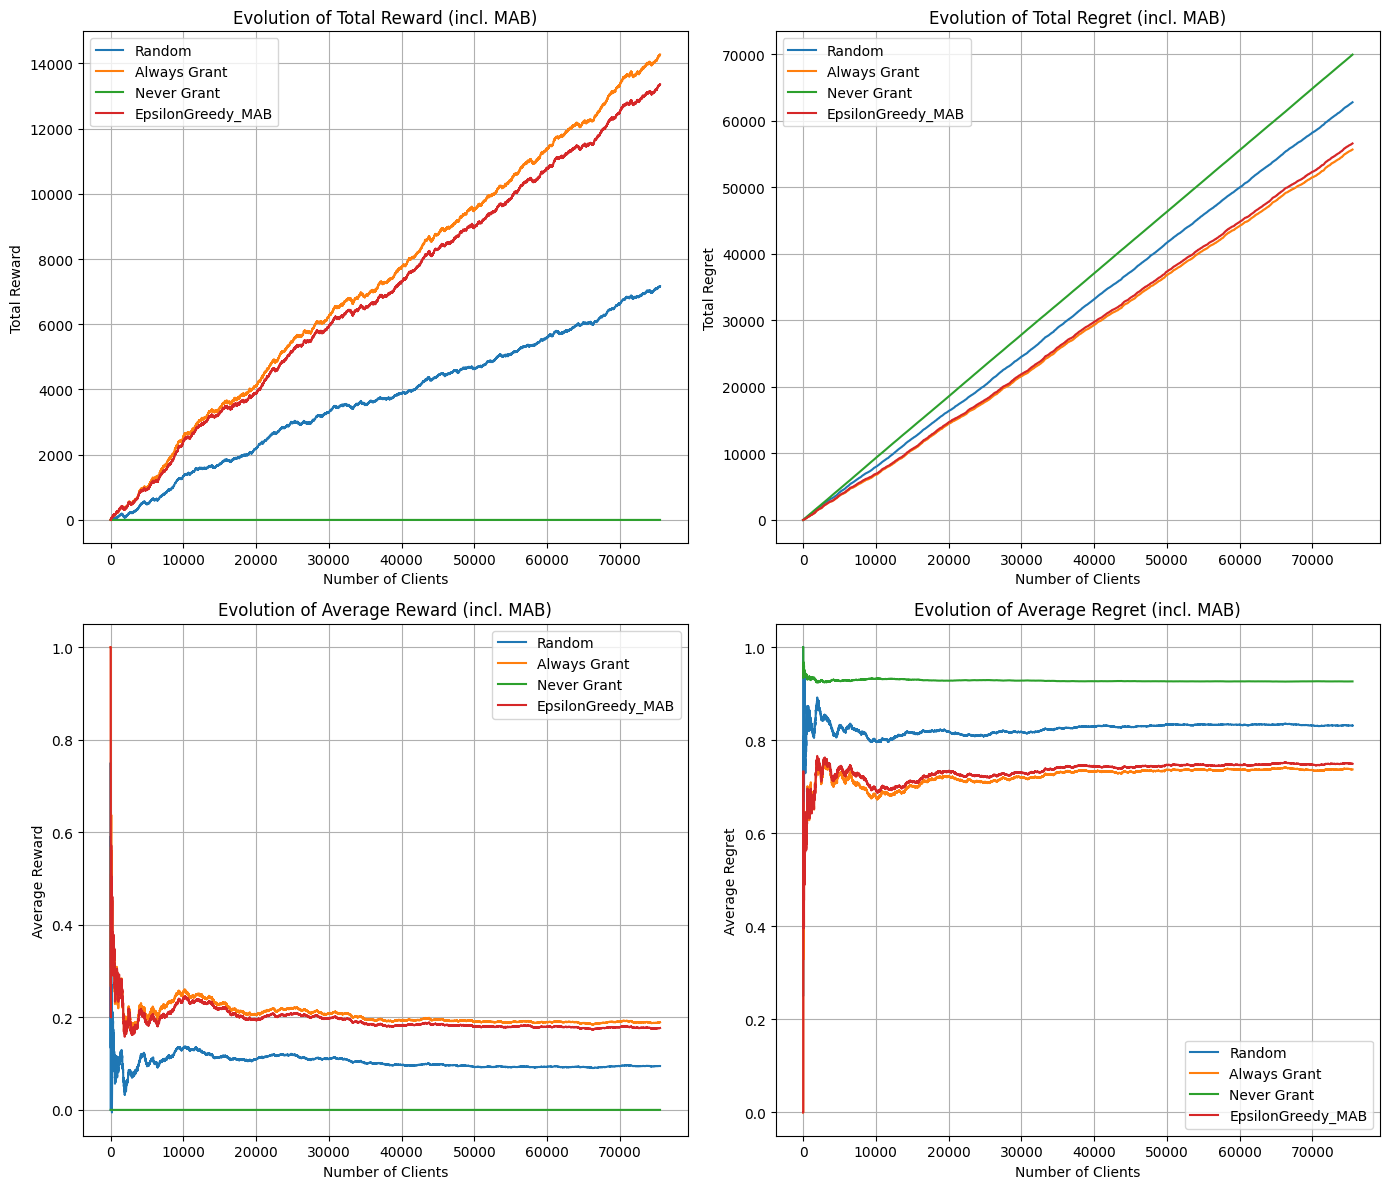

In [27]:
plt.figure(figsize=(14, 12))
iterations = range(1, N_train + 1)

# Plot 1: Total Reward Evolution
plt.subplot(2, 2, 1)
for policy_name, data in results.items():
    plt.plot(iterations, data["total_rewards"], label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Total Reward")
plt.title("Evolution of Total Reward (incl. MAB)")
plt.legend()
plt.grid(True)

# Plot 2: Total Regret Evolution
plt.subplot(2, 2, 2)
for policy_name, data in results.items():
    plt.plot(iterations, data["total_regrets"], label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Total Regret")
plt.title("Evolution of Total Regret (incl. MAB)")
plt.legend()
plt.grid(True)

# Calculate and Plot Average Reward
plt.subplot(2, 2, 3)
for policy_name, data in results.items():
    avg_rewards = [r / i for i, r in zip(iterations, data["total_rewards"])]
    plt.plot(iterations, avg_rewards, label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Average Reward")
plt.title("Evolution of Average Reward (incl. MAB)")
plt.legend()
plt.grid(True)

# Calculate and Plot Average Regret
plt.subplot(2, 2, 4)
for policy_name, data in results.items():
    avg_regrets = [r / i for i, r in zip(iterations, data["total_regrets"])]
    plt.plot(iterations, avg_regrets, label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Average Regret")
plt.title("Evolution of Average Regret (incl. MAB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Tarea 3

In [28]:
if COLAB:
  aux = "'https://docs.google.com/uc?export=download&id=1RGxAJE4jAJAdhsoMyXiYPiqiRUd7y2KR&confirm=t'"
  !wget $aux -O ./spacebandits.zip
  !unzip -qq -o ./spacebandits
  !rm ././spacebandits.zip

--2025-05-06 17:33:15--  https://docs.google.com/uc?export=download&id=1RGxAJE4jAJAdhsoMyXiYPiqiRUd7y2KR&confirm=t
Resolving docs.google.com (docs.google.com)... 142.250.200.110, 2a00:1450:4003:80e::200e
Connecting to docs.google.com (docs.google.com)|142.250.200.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1RGxAJE4jAJAdhsoMyXiYPiqiRUd7y2KR&export=download [following]
--2025-05-06 17:33:15--  https://drive.usercontent.google.com/download?id=1RGxAJE4jAJAdhsoMyXiYPiqiRUd7y2KR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.201.65, 2a00:1450:4003:811::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.201.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22144 (22K) [application/octet-stream]
Saving to: ‘./spacebandits.zip’

./spacebandits.zip  100%[===================>]  21,62K  --.-KB/s 

In [29]:
from space_bandits import LinearBandits

2025-05-06 17:33:19.134982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 17:33:19.135651: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 17:33:19.137865: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 17:33:19.143304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746545599.152273   43259 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746545599.15

Instructions for updating:
non-resource variables are not supported in the long term


In [30]:
cl_train_sim_contextual_mab = clientes(df_train.copy()) # Fresh simulation environment
N_train = len(df_train) # Already defined, but good for clarity here

# Determine the number of features from the context
# (Ensuring it's done within the cell for explicitness)
_temp_client_instance = clientes(df_train.iloc[:1]) # Small df to get context structure
_temp_client_instance.cliente()
num_features = len(_temp_client_instance.get_context().values)

# Initialize LinearBandits model
# num_actions = 2 (already known)
contextual_mab = LinearBandits(num_actions=2, num_features=num_features) 

# Store results
contextual_mab_total_rewards = []
contextual_mab_total_regrets = []
current_total_reward_contextual_mab = 0
current_total_regret_contextual_mab = 0

for step in tqdm(range(N_train), desc="Simulating Contextual Linear MAB"):
    cl_train_sim_contextual_mab.cliente()
    # Ensure context is a float64 numpy array as spacebandits might expect it
    context = cl_train_sim_contextual_mab.get_context().values.astype(np.float64) 
    
    action = contextual_mab.action(context)
    actual_reward = cl_train_sim_contextual_mab.get_reward(action)
    contextual_mab.update(context, action, actual_reward)
    
    # Optimal reward calculation
    reward_if_action_0 = 0
    if cl_train_sim_contextual_mab.df.iloc[cl_train_sim_contextual_mab.i]["SeriousDlqin2yrs"] == 1:
        reward_if_action_1 = -10
    else: # Paga
        reward_if_action_1 = 1
    optimal_reward_for_client = max(reward_if_action_0, reward_if_action_1)
    
    regret = optimal_reward_for_client - actual_reward
    
    current_total_reward_contextual_mab += actual_reward
    current_total_regret_contextual_mab += regret
    
    contextual_mab_total_rewards.append(current_total_reward_contextual_mab)
    contextual_mab_total_regrets.append(current_total_regret_contextual_mab)

results["Contextual_Linear_MAB"] = {
    "total_rewards": contextual_mab_total_rewards,
    "total_regrets": contextual_mab_total_regrets
}

print(f"\nContextual Linear MAB simulation finished.")
# We can inspect contextual_mab.beta later for interpretability if needed

Simulating Contextual Linear MAB: 100%|██████████| 75518/75518 [09:59<00:00, 126.04it/s]


Contextual Linear MAB simulation finished.


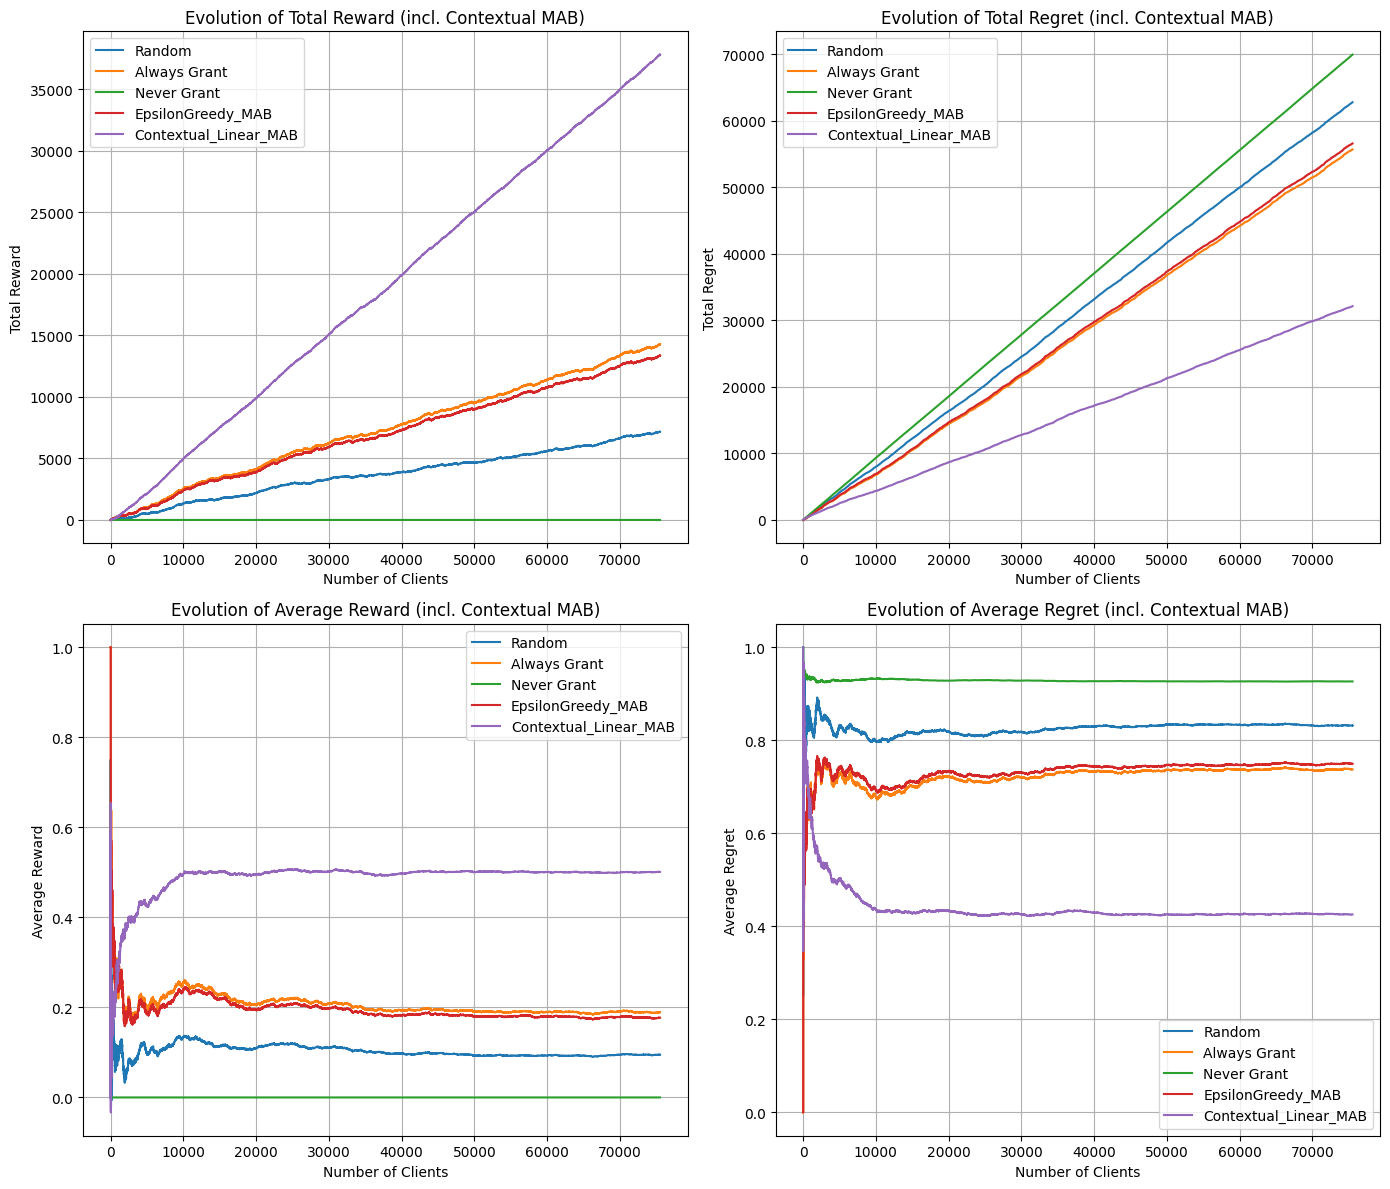

In [31]:
plt.figure(figsize=(14, 12))
iterations = range(1, N_train + 1) # N_train should be accessible

# Plot 1: Total Reward Evolution
plt.subplot(2, 2, 1)
for policy_name, data in results.items():
    plt.plot(iterations, data["total_rewards"], label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Total Reward")
plt.title("Evolution of Total Reward (incl. Contextual MAB)")
plt.legend()
plt.grid(True)

# Plot 2: Total Regret Evolution
plt.subplot(2, 2, 2)
for policy_name, data in results.items():
    plt.plot(iterations, data["total_regrets"], label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Total Regret")
plt.title("Evolution of Total Regret (incl. Contextual MAB)")
plt.legend()
plt.grid(True)

# Calculate and Plot Average Reward
plt.subplot(2, 2, 3)
for policy_name, data in results.items():
    avg_rewards = [r / i for i, r in zip(iterations, data["total_rewards"])]
    plt.plot(iterations, avg_rewards, label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Average Reward")
plt.title("Evolution of Average Reward (incl. Contextual MAB)")
plt.legend()
plt.grid(True)

# Calculate and Plot Average Regret
plt.subplot(2, 2, 4)
for policy_name, data in results.items():
    avg_regrets = [r / i for i, r in zip(iterations, data["total_regrets"])]
    plt.plot(iterations, avg_regrets, label=policy_name)
plt.xlabel("Number of Clients")
plt.ylabel("Average Regret")
plt.title("Evolution of Average Regret (incl. Contextual MAB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Tarea 4

In [32]:
# Ensure cl_train is initialized for fetching specific clients by index if needed,
# or we can just pick some rows from df_train directly.
# We'll use df_train directly to get a few sample clients.

num_clients_to_check = 3
# Make sure we don't pick more clients than available in df_train
sample_indices = np.random.choice(df_train.index, size=min(num_clients_to_check, len(df_train)), replace=False)
sample_clients_df = df_train.loc[sample_indices]

print(f"--- Analysing Q-values for {len(sample_clients_df)} sample clients ---")

# Original feature names from the dataframe
original_feature_names = df_train.drop(columns=["SeriousDlqin2yrs"]).columns.tolist()

for i, client_idx in enumerate(sample_clients_df.index):
    client_data = sample_clients_df.loc[client_idx]
    client_context_series = client_data.drop("SeriousDlqin2yrs")
    # Context as it comes from the data (10 features)
    context_np_original = client_context_series.values.astype(np.float64)

    print(f"\nClient {i+1} (Index: {client_idx}):")
    print(f"Original Context (10 features): {client_context_series.to_dict()}")

    # Add intercept term for manual calculation with model.mu
    context_with_intercept = np.insert(context_np_original, 0, 1.0) # Prepend 1.0 for intercept

    if hasattr(contextual_mab, 'mu'):
        # Assuming contextual_mab.mu is a list of 1D arrays, or a 2D array.
        # contextual_mab.mu[0] and contextual_mab.mu[1] should be accessible.
        q_calculated_action0 = np.dot(context_with_intercept, contextual_mab.mu[0])
        q_calculated_action1 = np.dot(context_with_intercept, contextual_mab.mu[1])
        q_values_calculated = np.array([q_calculated_action0, q_calculated_action1])
        print(f"  Calculated Q-values (expected reward for [action 0, action 1]): {q_values_calculated}")

        chosen_action_thompson = contextual_mab.action(context_np_original)
        print(f"  Action chosen by model.action(original_context) (Thompson Sampling): {chosen_action_thompson}")

        best_action_by_calculated_q = np.argmax(q_values_calculated)
        print(f"  Action with highest calculated Q-value: {best_action_by_calculated_q}")

        if chosen_action_thompson == best_action_by_calculated_q:
            print(f"  Thompson action ({chosen_action_thompson}) MATCHES action with highest calculated Q-value ({best_action_by_calculated_q}).")
        else:
            if np.allclose(q_values_calculated[0], q_values_calculated[1]):
                 print(f"  Thompson action ({chosen_action_thompson}) DOES NOT MATCH action with highest calculated Q-value ({best_action_by_calculated_q}), BUT Q-values are very close.")
            else:
                print(f"  Thompson action ({chosen_action_thompson}) DOES NOT MATCH action with highest calculated Q-value ({best_action_by_calculated_q}). This can happen due to sampling.")
    else:
        print("  Model attribute 'mu' not found. Has the model been updated (trained)?")

if hasattr(contextual_mab, 'mu'):
    print("\n--- Contextual MAB Mu Weights (Rows: Actions, Columns: Features + Intercept) ---")
    feature_names_with_intercept = ["intercept"] + original_feature_names
    
    mu_for_df = None
    if isinstance(contextual_mab.mu, list):
        try:
            # If mu is a list of 1D arrays, np.array() should stack them into a 2D array
            mu_for_df = np.array(contextual_mab.mu)
        except Exception as e:
            print(f"  Could not convert contextual_mab.mu (list) to a 2D NumPy array: {e}")
            print(f"  Raw contextual_mab.mu: {contextual_mab.mu}")
    elif hasattr(contextual_mab.mu, 'shape'): # If it's already a NumPy array
        mu_for_df = contextual_mab.mu
    else:
        print(f"  contextual_mab.mu is neither a list nor a NumPy array. Type: {type(contextual_mab.mu)}")

    if mu_for_df is not None and hasattr(mu_for_df, 'shape') and mu_for_df.ndim == 2:
        if mu_for_df.shape[1] == len(feature_names_with_intercept):
            mu_df = pd.DataFrame(mu_for_df, columns=feature_names_with_intercept, index=[f"Action {j}" for j in range(contextual_mab.hparams.num_actions)])
            print(mu_df)
        else:
            print(f"  Shape mismatch for mu_df: mu_for_df has shape {mu_for_df.shape} but {len(feature_names_with_intercept)} column names expected.")
            print("  Mu_for_df values:")
            print(mu_for_df)
    elif mu_for_df is not None:
         print(f"  mu_for_df was created but is not a 2D array. Shape: {mu_for_df.shape if hasattr(mu_for_df, 'shape') else 'N/A'}")
         print(f"  Mu_for_df values: {mu_for_df}")
else:
    print("\nModel attribute 'mu' not found for printing weights.")


--- Analysing Q-values for 3 sample clients ---

Client 1 (Index: 15209):
Original Context (10 features): {'RevolvingUtilizationOfUnsecuredLines': 0.091058165, 'age': 52.0, 'NumberOfTime30-59DaysPastDueNotWorse': 0.0, 'DebtRatio': 0.317115252, 'MonthlyIncome': 8693.0, 'NumberOfOpenCreditLinesAndLoans': 14.0, 'NumberOfTimes90DaysLate': 0.0, 'NumberRealEstateLoansOrLines': 3.0, 'NumberOfTime60-89DaysPastDueNotWorse': 0.0, 'NumberOfDependents': 1.0}
  Calculated Q-values (expected reward for [action 0, action 1]): [   0.         -176.76346141]
  Action chosen by model.action(original_context) (Thompson Sampling): 1
  Action with highest calculated Q-value: 0
  Thompson action (1) DOES NOT MATCH action with highest calculated Q-value (0). This can happen due to sampling.

Client 2 (Index: 49127):
Original Context (10 features): {'RevolvingUtilizationOfUnsecuredLines': 0.930559308, 'age': 37.0, 'NumberOfTime30-59DaysPastDueNotWorse': 3.0, 'DebtRatio': 0.213664748, 'MonthlyIncome': 8166.0, '

### Tarea 5

### Tarea 6

### Tarea 7

### Tarea 8

### Tarea 9 (opcional)